In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers

# Setup

In [3]:
SUMMARY_PATH = '../results/summaries'
VALID_RESPONSES_PATH = '../results/valid_responses'
PLOTS_PATH = '../results/plots'
io.validate_path(PLOTS_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

# Data

In [5]:
# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)
df_summary.head(1)

,model,temperature,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,SiliconFlow,NaN,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,1,NaN,NaN,NaN,False,provider_error,API returned error response: Provider returned...,../data/data-temperature/temperature_0.0/confi...,False


In [6]:
# check if there are models with missing temperature values
df_validity = df_summary.query("task_name in @constants.EXPERIMENT_TASKS").copy()
_tmp = df_validity.groupby('model')['temperature'].apply(lambda x: len(set(x)) != len(constants.TEMPERATURE_VALUES))
_tmp.reset_index(name='missing_temperatures').query("missing_temperatures")

,model,missing_temperatures


# Temperature

In [7]:
df_validity.loc[:, 'temperature'] = df_validity.loc[:,'temperature'].apply(lambda x: (x/2.)*100)

In [8]:
df_validity.result_valid_flag.unique()

array(['valid', 'provider_error', 'invalid', 'truncated-dict', 'verbose'],
      dtype=object)

In [31]:
_tmp = df_validity.query("model == 'gemini-2.5-flash-grounded' and result_valid_flag != 'valid'")[['task_name','task_param','task_attempt','result_is_valid', 'result_valid_flag', 'result_original_message', 'file_path', 'valid_attempt']]
# _tmp.result_original_message.unique() 
_tmp.loc[1689].file_path

'../data/data-temperature/temperature_2.0/config_gemini-2.5-flash-grounded/run_20250930_202108/twins_random_female/attempt1_20250930_205411.json'

## Validity of responses

In [10]:
group_columns = ['temperature', 'model', 'result_valid_flag']
df_validity_normalized = df_validity[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_validity_normalized['normalized_counts'] = df_validity_normalized['counts'] / df_validity_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_validity_normalized['result_valid_flag'] = io.pd.Categorical(df_validity_normalized['result_valid_flag'], categories=constants.EXPERIMENT_OUTPUTS_ORDER, ordered=True)
df_validity_normalized.head(10)

,temperature,model,result_valid_flag,counts,normalized_counts
0,0.0,deepseek-chat-v3.1,invalid,6,0.285714
1,0.0,deepseek-chat-v3.1,provider_error,3,0.142857
2,0.0,deepseek-chat-v3.1,valid,12,0.571429
3,0.0,deepseek-r1-0528,invalid,4,0.222222
4,0.0,deepseek-r1-0528,valid,14,0.777778
5,0.0,gemini-2.5-flash,invalid,17,0.586207
6,0.0,gemini-2.5-flash,valid,12,0.413793
7,0.0,gemini-2.5-flash-grounded,invalid,27,0.729730
8,0.0,gemini-2.5-flash-grounded,valid,10,0.270270
9,0.0,gemini-2.5-pro,invalid,6,0.333333


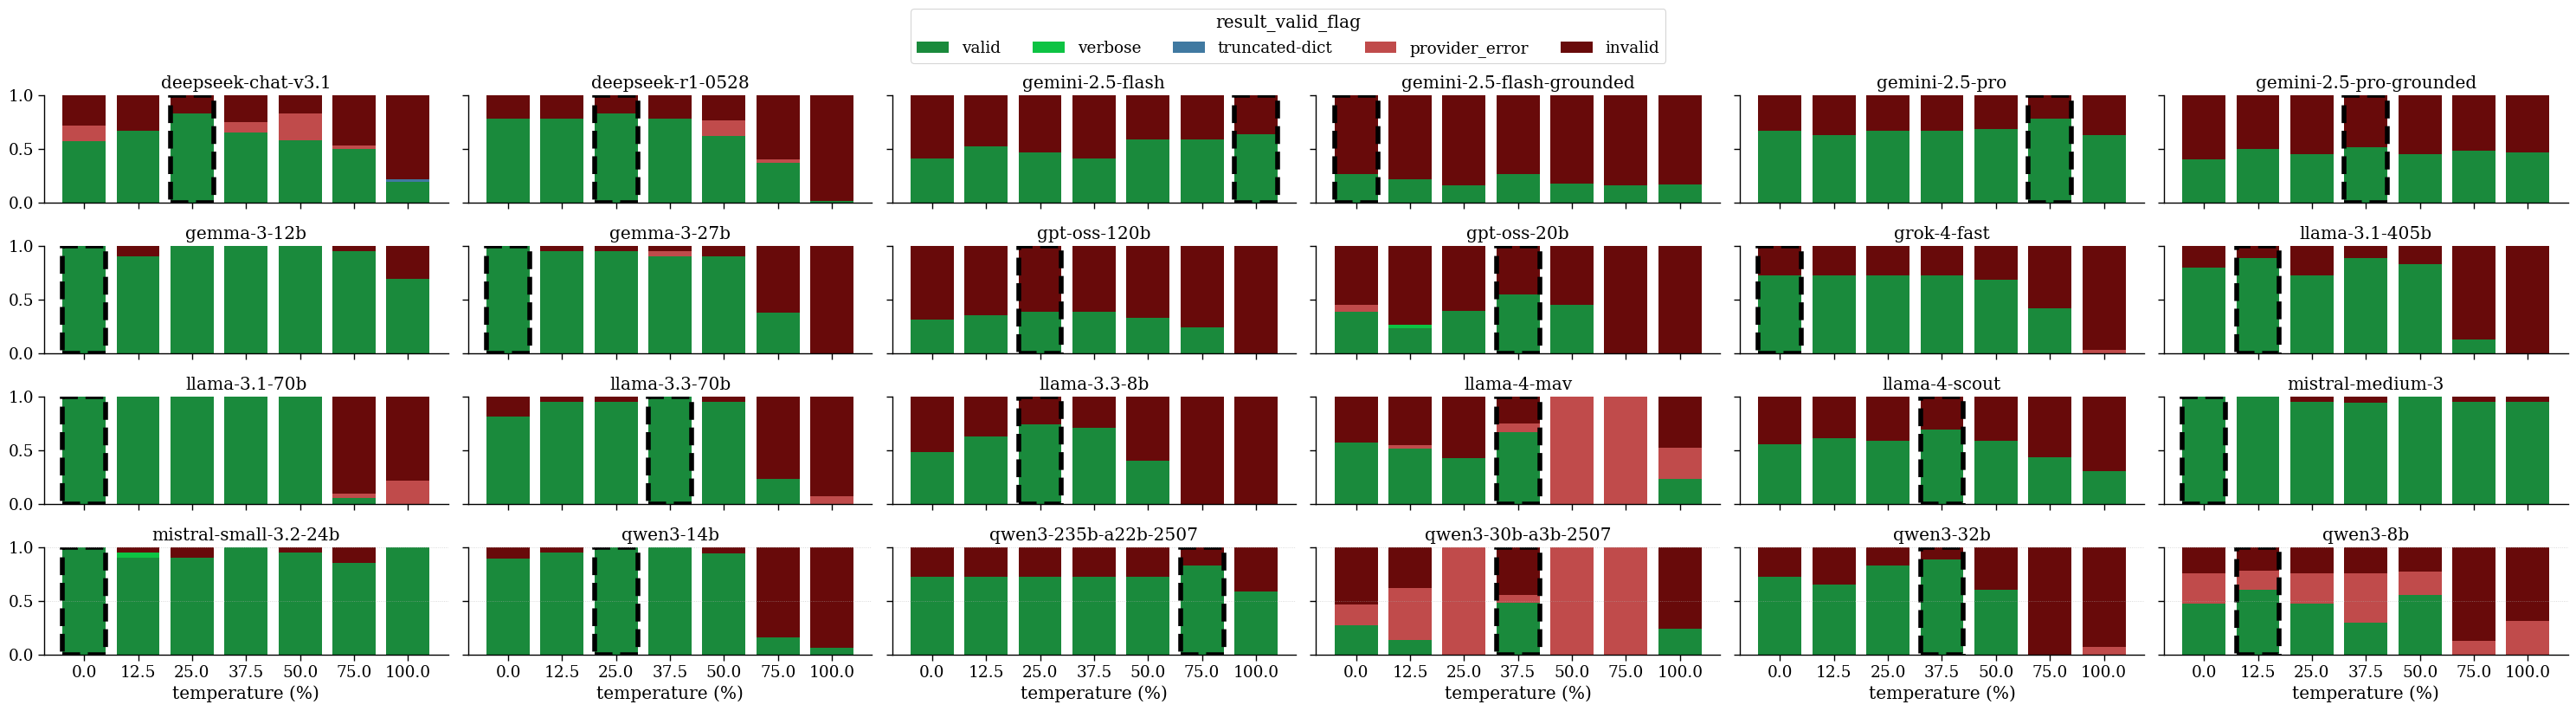

In [27]:
from tkinter import N
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

df = df_validity_normalized.copy()
groups = df_validity_normalized.result_valid_flag.unique().categories

# 4) prepare plotting
models = df['model'].unique()
n_models = len(models)

ncols = 6
nrows = int(np.ceil(n_models / ncols))
width = 5. * ncols
height = 2. * nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)

if n_models == 1:
    axes = [axes]  # make iterable

for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        if idx >= n_models:
            fig.delaxes(axes[row, col])  # remove unused axes

        ax = axes[row, col]
        model = models[idx]
        sub = df[df['model'] == model]
        ax.set_title(model)

        # pivot to temperature × flag (values: normalized_counts), sort temperatures numerically
        pivot = (
            sub.pivot_table(
                index='temperature',
                columns='result_valid_flag',
                values='normalized_counts',
                aggfunc='sum',
                fill_value=0.0,
                observed=False
            )
            .reindex(columns=groups)
            .sort_index(key=lambda s: pd.to_numeric(s, errors='coerce'))  # ensures numeric order
        )

        # choose a single best temperature: max 'a', ties → lowest temperature
        valid_series = pivot[constants.EXPERIMENT_OUTPUT_VALID] if constants.EXPERIMENT_OUTPUT_VALID in pivot.columns else pd.Series(0.0, index=pivot.index)
        max_valid = valid_series.max()
        if pd.isna(max_valid):
            best_idx = None
        else:
            best_idx = valid_series[valid_series == max_valid].index[0]  # first after numeric sort = lowest temp

        x = np.arange(len(pivot.index))
        bottoms = np.zeros(len(x), dtype=float)
        xtick_labels = pivot.index.tolist()

        # draw stacked bars
        bar_width = 0.8
        for flag in groups:
            vals = pivot[flag].to_numpy() if flag in pivot.columns else np.zeros(len(x))
            ax.bar(x, vals, bottom=bottoms, width=bar_width, color=constants.EXPERIMENT_OUTPUT_COLORS[flag], edgecolor='none', label=flag)
            bottoms += vals

        # single rectangle around the chosen temperature, height = 1.0
        if best_idx is not None:
            j = np.where(pivot.index == best_idx)[0][0]  # bar position
            rect = plt.Rectangle((x[j] - bar_width/2, 0.0), 
                                 bar_width, 
                                 1.0,
                                 ls='--',
                                 fill=False, edgecolor='black', linewidth=4.0)
            ax.add_patch(rect)

        # y-limit to ensure the rectangle is fully visible up to 1.0
        ymax = max(1.0, float(bottoms.max()))
        ax.set_ylim(0.0, ymax)

# cosmetics
for ax in axes[-1,:]:
    ax.set_xlabel("temperature (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=0)
    ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# put a single legend at the top
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title="result_valid_flag", ncol=len(groups), loc='upper center', bbox_to_anchor=(0.5, 1.04))

# final
plt.tight_layout(rect=[0,0,1,0.96])
plt.subplots_adjust(hspace=0.4, wspace=0.05)
plt.show()
plt.close()